# Lecture 11 worksheet solutions

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.datasets import load_iris

import statsmodels.api as sm
import pymc3 as pm
from pymc3 import glm
import arviz as az

from IPython.display import Image
sns.set(style="dark")
plt.style.use("ggplot")

## Problem 1: Goodness of fit for linear models

### Q1 a)

Based on visually inspecting the following plot, can you tell if the linear model is misspecified?

*Hint: Check out the assumptions of the linear model [here](https://bookdown.org/egarpor/PM-UC3M/lm-i-assumps.html).*

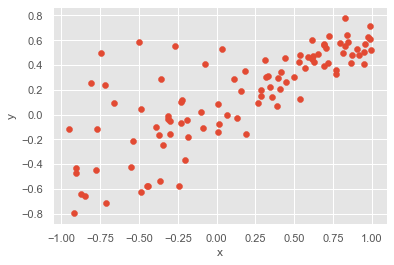

In [2]:
q1a_df = pd.read_csv("q1a.csv", index_col = 0)
plt.scatter(q1a_df["x"], q1a_df["y"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

**Solution**: The points with smaller x value have larger variance. This violates the homoscedasticity assumption for linear models.

### Q1 b)

We now try to fit a linear model and do a QQ-plot to examine goodness of fit. Briefly read about QQ-plots [here](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) or your favorite reference.

In [3]:
gaussian_model = sm.GLM(
    q1a_df.y, sm.add_constant(q1a_df.x), 
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                        0.058628
Method:                          IRLS   Log-Likelihood:                0.94306
Date:                Mon, 22 Feb 2021   Deviance:                       5.7456
Time:                        00:47:21   Pearson chi2:                     5.75
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0889      0.025      3.567      0.0

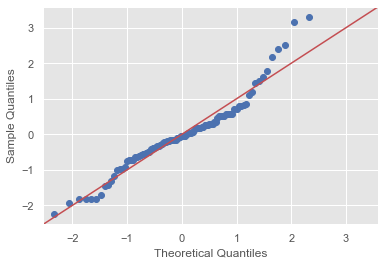

In [4]:
sm.qqplot(gaussian_results.resid_response / np.std(gaussian_results.resid_response), line = "45")
plt.show()

We are comparing the sample distribution of the residuals to the standard normal distribution. What can we say about the goodness-of-fit from this plot? Which assumption of the linear model are we checking?

**Solution**: QQ-plots plots are used to see if two distributions are similar. Each plotted point corresponds to a number $0 \leq q \leq 1$, and has $x$-coordinate equal to the $q$-th quantile of the first distribution, while the $y$-coordinate equals the $q$-th quantile of the second distribution. If the two distributions are equal, then the points will all lie on a 45 degree line (plotted in red).

For our QQ-plot, the horizontal distribution is the Gaussian, whereas the vertical distribution is the sample distribution of the residuals from the model. Under the linear model assumptions, the residuals are Gaussian so the sample distribution should also be Gaussian.

## Problem 2: Interpreting logistic model

In this problem, we fit a logistic regression model on a subset of the famous [iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset. We have 100 samples of iris flowers, and measure their sepal length, sepal width, petal length and petal width. The response labels are whether they belong to the *Virginica* species (1) or the *Versicolor* species (0).

In [5]:
X, y = load_iris(return_X_y=True)
iris_subset = pd.DataFrame(X[y!=0,:],
                           columns = ["sepal_length", "sepal_width", 
                                      "petal_length", "petal_width"])
y = y[y!=0] - 1
iris_subset["species"] = y

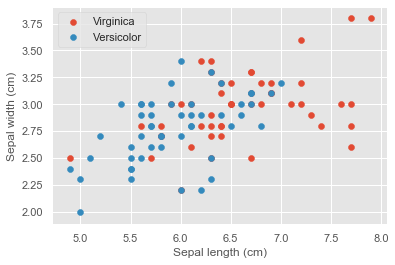

In [6]:
virginica_filter = (y==1)
plt.scatter(iris_subset[virginica_filter]["sepal_length"], 
            iris_subset[virginica_filter]["sepal_width"],
            label = "Virginica")
plt.scatter(iris_subset[~virginica_filter]["sepal_length"], 
            iris_subset[~virginica_filter]["sepal_width"],
            label = "Versicolor")

plt.xlabel("Sepal length (cm)")
plt.ylabel("Sepal width (cm)")
plt.legend()
plt.show()

We fit a model only with the sepal features.

In [7]:
logistic_model = sm.GLM(
    iris_subset["species"], sm.add_constant(iris_subset[["sepal_width", "sepal_length"]]), 
    family=sm.families.Binomial()
)
logistic_results = logistic_model.fit()
print(logistic_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                species   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -55.163
Date:                Mon, 22 Feb 2021   Deviance:                       110.33
Time:                        00:47:22   Pearson chi2:                     100.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -13.0460      3.097     -4.212   

### Q2 a)

Assuming that the model is correct, write in one sentence an interpretation for the logistic model with respect to sepal length.

*Hint: Recall that the logistic model is*

$$\log\left(\frac{p}{1-p}\right) = x^T\beta$$

*where $p$ is the probability of the sample with feature vector $x$ being in class 1. The quantity on the left hand side is called the log odds ratio*.

**Solution**: Holding sepal width constant, every 1 cm increase in sepal length increases the log odds of the iris belonging to I. Virginica (rather than I. Versicolor) increases by between 0.9 and 2.9.

### Q2 b)

What happens to the interpretation if the model is misspecified?

**Solution**: Then the interpretation is only valid with respect to the projected model.

### Q2 c)

We now also include petal width in our model. Which model has a better fit? How can you tell?

**Solution**: The larger model is a better fit, because the loglikelihood is larger, while deviance and pearson chi2 are smaller. 

In [8]:
logistic_model = sm.GLM(
    iris_subset["species"], sm.add_constant(iris_subset[["sepal_width", "sepal_length", "petal_width"]]), 
    family=sm.families.Binomial()
)
logistic_results = logistic_model.fit()
print(logistic_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                species   No. Observations:                  100
Model:                            GLM   Df Residuals:                       96
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12.951
Date:                Mon, 22 Feb 2021   Deviance:                       25.902
Time:                        00:47:22   Pearson chi2:                     32.6
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -20.2873      8.055     -2.519   

### More observations:

1. Coefficients are different. If the larger model is "correct", then this is called omitted variable bias (an important topic in econometrics).
2. The std error for the smaller model does not account for this bias (model misspecification)
3. Hence, for models without good fit, interpretations of the fitted model do not extend to the data generating process

Q. It could be the case that for the some data, we can have two very different models, Model A and Model B, both achieving very good fit. In this case, which should we use to interpret the data generating process?

It's impossible to conclude from goodness of fit alone which model generates the data. We usually use the principle of parsimony (choose the simpler model). But this is more of a heuristic rather than anything rigorous. Deciding which model to trust is a big question in data science, and the topic of current research. At the end of the day, as a data scientist, we have to make some assumptions. If we want to establish causality (rather than just correlation) for the model, we will have to work even harder by either collecting better data, or making more assumptions.